# CNN with 4 image imputs

## ERP PREDICTION CONTEST
### By Jonas Lundgren

The UCSB Department of Statistics & Applied Probability and the Center for Financial Mathematics and Actuarial Research are partnering with Hull Tactical to run a data science contest on predicting the S&P 500 returns.
Link to competition: https://ucsb-erp-contest.herokuapp.com/

__Fastai and Pytoch will be used through out this notebook__

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

Setting the path to the folder `images`.

In [3]:
path = Path('images'); path

PosixPath('images')

Creating function `get_labels` to get the label from image title.

In [4]:
def get_labels(file_path): return float(str(file_path).split(",")[1].split(".p")[0])

Loading the training and validation `percentage` data from folders train_percentage and validation_percentage in path. 

In [5]:
data_percentage = (ImageList.from_folder(path)
                .split_by_folder(train = "train_percentage", valid = "validation_percentage")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

Displaying the images with corresponding target variable.

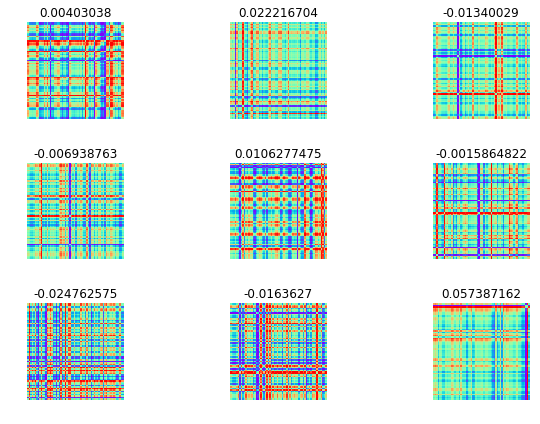

In [6]:
data_percentage.show_batch(3, figsize=(9,6))

Creating a fastai learer object with ResNet50 structure. Loading previously trained model.

In [7]:
learn_percentage = cnn_learner(data_percentage, models.resnet50, metrics = [r2_score, root_mean_squared_error])
learn_percentage.load('percentage-stage1');

Storing the last layer of the pretrained network as `last_layers_percentage` and removing the layer from the network.

In [8]:
last_layers_percentage = list(children(learn_percentage.model))[-1][-1]
learn_percentage.model[-1] = learn_percentage.model[-1][:-1]
last_layers_percentage

Linear(in_features=512, out_features=1, bias=True)

Loading the training and validation `BBdiff` data from folders train_BBdiff and validation_BBdiff in path. 

In [9]:
data_BBdiff = (ImageList.from_folder(path)
                .split_by_folder(train = "train_BBdiff", valid = "validation_BBdiff")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

Displaying the images with corresponding target variable.

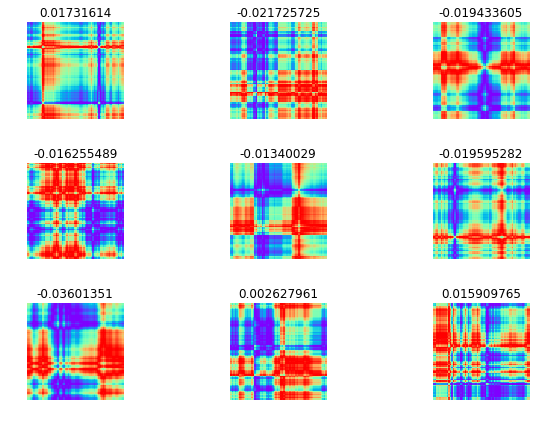

In [10]:
data_BBdiff.show_batch(3, figsize=(9,6))

Creating a fastai learer object with ResNet50 structure. Loading previously trained model.

In [11]:
learn_BBdiff = cnn_learner(data_BBdiff, models.resnet50, metrics = [r2_score, root_mean_squared_error])
learn_BBdiff.load('BBdiff-stage1');

Storing the last layer of the pretrained network as last_layers_BBdiff and removing the layer from the network.

In [12]:
last_layers_BBdiff = list(children(learn_BBdiff.model))[-1][-1]
learn_BBdiff.model[-1] = learn_BBdiff.model[-1][:-1]
last_layers_BBdiff

Linear(in_features=512, out_features=1, bias=True)

Loading the training and validation `MA20050diff` data from folders train_MA20050diff and validation_MA20050diff in path.

In [13]:
data_MA20050diff = (ImageList.from_folder(path)
                .split_by_folder(train = "train_MA20050diff", valid = "validation_MA20050diff")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

Displaying the images with corresponding target variable.

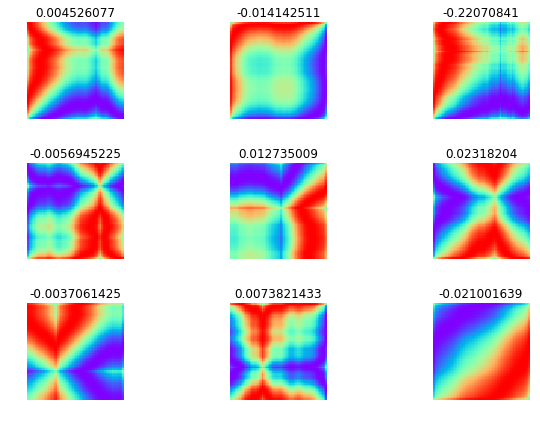

In [14]:
data_MA20050diff.show_batch(3, figsize=(9,6))

Creating a fastai learer object with ResNet50 structure. Loading previously trained model.

In [15]:
learn_MA20050diff = cnn_learner(data_MA20050diff, models.resnet50, metrics = [r2_score, root_mean_squared_error])
learn_MA20050diff.load('MA20050diff-stage1');

Storing the last layer of the pretrained network as last_layers_MA20050diff and removing the layer from the network.

In [16]:
last_layers_MA20050diff = list(children(learn_MA20050diff.model))[-1][-1]
learn_MA20050diff.model[-1] = learn_MA20050diff.model[-1][:-1]
last_layers_MA20050diff

Linear(in_features=512, out_features=1, bias=True)

Loading the training and validation `MACD` data from folders train_MACD and validation_MACD in path.

In [17]:
data_MACD = (ImageList.from_folder(path)
                .split_by_folder(train = "train_MACD", valid = "validation_MACD")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

Displaying the images with corresponding target variable.

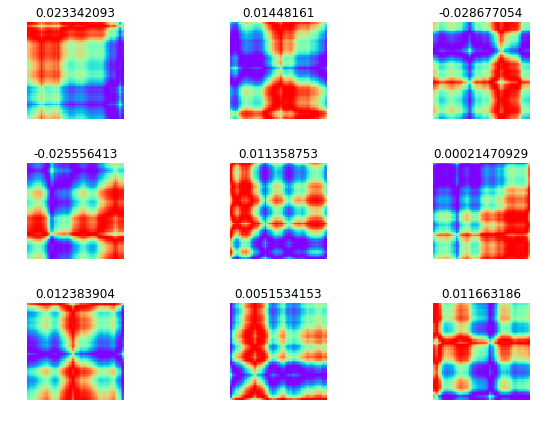

In [18]:
data_MACD.show_batch(3, figsize=(9,6))

Creating a fastai learer object with ResNet50 structure. Loading previously trained model.

In [19]:
learn_MACD = cnn_learner(data_MACD, models.resnet50, metrics = [r2_score, root_mean_squared_error])
learn_MACD.load('MACD-stage1');

Storing the last layer of the pretrained network as last_layers_MACD and removing the layer from the network.

In [20]:
last_layers_MACD = list(children(learn_MACD.model))[-1][-1]
learn_MACD.model[-1] = learn_MACD.model[-1][:-1]
last_layers_MACD

Linear(in_features=512, out_features=1, bias=True)

Overwriting the Dataset object to be able to take in several inputs.

In [21]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, x3, x4, y): 
        self.x1,self.x2,self.x3,self.x4,self.y = x1,x2,x3,x4,y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): 
        imgTensor1 = self.x1[i].data
        imgTensor2 = self.x2[i].data
        imgTensor3 = self.x3[i].data
        imgTensor4 = self.x4[i].data
        y = torch.from_numpy(self.y[i].data)
        
        return (imgTensor1, imgTensor2, imgTensor3, imgTensor4), y

Creating datasets `train_ds`, `valid_ds` to be able to take in several inputs and corresponding target variable.

In [22]:
train_ds = ConcatDataset(data_percentage.train_ds.x, data_BBdiff.train_ds.x,
                         data_MA20050diff.train_ds.x, data_BBdiff.train_ds.x,
                         data_percentage.train_ds.y)
valid_ds = ConcatDataset(data_percentage.valid_ds.x, data_BBdiff.valid_ds.x,
                         data_MA20050diff.valid_ds.x, data_BBdiff.valid_ds.x,
                         data_percentage.valid_ds.y)

Converting to dataloader objects with batch size 64 and creating a DataBunch object `data`.

In [23]:
bs = 64
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)
data = DataBunch(train_dl, valid_dl)

Displaying the 4 different inputs.

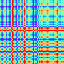

In [24]:
data.train_ds.x1[0]

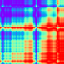

In [25]:
data.train_ds.x2[0]

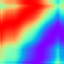

In [26]:
data.train_ds.x3[0]

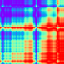

In [27]:
data.train_ds.x4[0]

Crearing the network structur taking in 4 Networks and the 4 last layers which are combined into 1 last layer.

In [28]:
class ConcatModel(nn.Module):
    def __init__(self, cnn_1, cnn_2, cnn_3, cnn_4, last_layers_1, last_layers_2, last_layers_3, last_layers_4):
        super().__init__()
        self.cnn_1 = cnn_1
        self.cnn_2 = cnn_2
        self.cnn_3 = cnn_3
        self.cnn_4 = cnn_4
               
        self.last_layers = nn.Linear(4*512, 1, True)
        self.last_layers.weight[0].data[0:512] = last_layers_1.weight[0].data
        self.last_layers.weight[0].data[512:2*512] = last_layers_2.weight[0].data
        self.last_layers.weight[0].data[2*512:3*512] = last_layers_3.weight[0].data
        self.last_layers.weight[0].data[3*512:4*512] = last_layers_4.weight[0].data
        
    def forward(self, x1, x2, x3, x4):
        x1 = self.cnn_1(x1)
        x2 = self.cnn_2(x2)
        x3 = self.cnn_3(x3)
        x4 = self.cnn_4(x4)
        
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.last_layers(x)
        
        return x

The model is created.

In [29]:
model = ConcatModel(learn_percentage.model, learn_BBdiff.model, learn_MA20050diff.model, learn_MACD.model, 
                    last_layers_percentage, last_layers_BBdiff, last_layers_MA20050diff, last_layers_MACD)

Specifying the layer groups for the Learner.

In [30]:
layer_groups = [nn.Sequential(*flatten_model(learn_percentage.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_percentage.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_percentage.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_BBdiff.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_BBdiff.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_BBdiff.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_MA20050diff.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_MA20050diff.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_MA20050diff.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_MACD.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_MACD.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_MACD.layer_groups[2]))] 

Creating the learner and training the network. I'm not too sure that the `lr_find` function works for this structure and the training is not as straight forward using this structure.

In [31]:
learn = Learner(data, model, metrics= [r2_score, root_mean_squared_error], layer_groups=layer_groups)

In [41]:
learn.fit_one_cycle(9)

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.004653,0.000986,-1.324096,0.029971,01:38
1,0.004358,0.002431,-5.385141,0.043006,01:37
2,0.004063,0.005922,-15.215036,0.062145,01:38
3,0.004582,0.004525,-11.086220,0.055589,01:37
4,0.003982,0.001722,-3.355489,0.038304,01:37
5,0.003966,0.002288,-4.352775,0.042129,01:38
6,0.003945,0.003561,-7.186574,0.049117,01:37
7,0.003274,0.001886,-3.164395,0.037931,01:37
8,0.003465,0.001296,-1.829872,0.033117,01:38


In [42]:
learn.save('percentage+BBdiff+MA20050diff+MACD-stage1')

In [32]:
learn.load('percentage+BBdiff+MA20050diff+MACD-stage1');

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConcatModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [50]:
learn.fit_one_cycle(3, 0.001)

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.003447,0.038551,-94.364586,0.142816,01:39
1,0.003753,0.001273,-1.873409,0.033938,01:39
2,0.003050,0.001287,-1.867226,0.033230,01:39


In [51]:
learn.save('percentage+BBdiff+MA20050diff+MACD-stage2')

In [52]:
learn.fit_one_cycle(3, 0.0003)

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.003323,0.001006,-1.209027,0.030014,01:38
1,0.003141,0.004567,-9.431121,0.054228,01:38
2,0.003105,0.000999,-1.308110,0.030130,01:39


In [53]:
learn.save('percentage+BBdiff+MA20050diff+MACD-stage3')

In [33]:
learn.load('percentage+BBdiff+MA20050diff+MACD-stage3');

In [33]:
learn.fit_one_cycle(6, 0.0003)

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,0.003026,0.000791,-0.701205,0.026916,02:22
1,0.003433,0.006441,-13.091903,0.064657,01:38
2,0.003312,0.002864,-5.312780,0.046428,01:38
3,0.003019,0.001593,-2.665962,0.036509,01:39
4,0.003176,0.000749,-0.661041,0.026234,01:38
5,0.002676,0.000748,-0.626073,0.026089,01:38


In [35]:
learn.save('percentage+BBdiff+MA20050diff+MACD-stage4')

In [34]:
learn.load('percentage+BBdiff+MA20050diff+MACD-stage4');

Loading the testing data and testing the model

https://docs.fast.ai/data_block.html#Add-a-test-set

In [50]:
data_percentage_test = (ImageList.from_folder(path)
                .split_by_folder(train = "train_percentage", valid = "test_percentage")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

data_BBdiff_test= (ImageList.from_folder(path)
                .split_by_folder(train = "train_BBdiff", valid = "test_BBdiff")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

data_MA20050diff_test = (ImageList.from_folder(path)
                .split_by_folder(train = "train_MA20050diff", valid = "test_MA20050diff")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

data_MACD_test = (ImageList.from_folder(path)
                .split_by_folder(train = "train_MACD", valid = "test_MACD")
                .label_from_func(get_labels)
                .databunch().normalize(imagenet_stats)
            )

train_ds = ConcatDataset(data_percentage_test.train_ds.x, data_BBdiff_test.train_ds.x,
                         data_MA20050diff_test.train_ds.x, data_MACD_test.train_ds.x,
                         data_percentage_test.train_ds.y)
test_ds = ConcatDataset(data_percentage_test.valid_ds.x, data_BBdiff_test.valid_ds.x,
                        data_MA20050diff_test.valid_ds.x, data_MACD_test.valid_ds.x,
                        data_percentage_test.valid_ds.y)

bs = 64
train_dl = DataLoader(train_ds, bs)
test_dl = DataLoader(test_ds, bs)
data_test = DataBunch(train_dl, test_dl)

In [51]:
data_test.test_dl

Validate using the out of sample test set.

In [52]:
pred_metrics = learn.validate(data_test.test_dl)

Displaying the testing metrics [MSE, $R^2$, RMSE]

In [53]:
pred_metrics

[0.00074751663, tensor(-0.6261), tensor(0.0261)]